In [1]:
import os
import gc
import sys
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:5


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

> ### Train-test-split

In [7]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [8]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1

In [9]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [10]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)

> ### Scaling

In [11]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

> ### Dataset and dataloader

In [12]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [13]:
FAULT_START_TRAINVAL = 20
FAULT_START_TEST = 160

In [14]:
class DataTEP(Dataset):

    def __init__(self, X):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')
        
        self.max_length = self.X['sample'].max()

        self.s_list = [FAULT_START_TRAINVAL, FAULT_START_TRAINVAL + 200]
        self.l_list = [200]
        
#         self.s_list = [FAULT_START_TRAINVAL]
#         self.l_list = [50, 100]
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique() * len(self.s_list) * len(self.l_list)
    
    def __getitem__(self, idx):
        
        fault_sim_idx = idx // (len(self.s_list) * len(self.l_list))
    
        start_length_idxs = idx % (len(self.s_list) * len(self.l_list))
        
        start_idx = self.s_list[start_length_idxs // len(self.l_list)]
        seq_length = self.l_list[start_length_idxs % len(self.l_list)]

        features = self.X.loc[fault_sim_idx][self.features].values[start_idx : (start_idx+seq_length), :]
        target = self.X.loc[fault_sim_idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [15]:
BATCH_SIZE = 64
NUM_CLASSES = 21

In [16]:
def collate_fn(batch):

    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
        
    lengths = torch.LongTensor([len(x) for x in sequences])
    lengths, idx = lengths.sort(0, descending=True)
    
    sequences = [sequences[i] for i in idx]
    
    labels = torch.tensor(labels, dtype=torch.long)[idx]
    
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels

In [17]:
train_ds = DataTEP(X_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_ds = DataTEP(X_val)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

In [18]:
train_ds[1000][1]

tensor(1)

In [19]:
len(train_ds), len(val_ds)

(16800, 4200)

In [20]:
gc.collect()

0

> ### Models

In [21]:
class UniRNN(nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type,
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional,
            "DESCRIPTION": self.description,
            }
            
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        x_rnn_out, _ = self.rnn(x_packed)
        x_unpacked, _ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        x = self.head(x_last_hiddens)
        
        return x

In [22]:
class AttentionModel(torch.nn.Module):
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL):
        super().__init__()
        
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        rnn_cell = getattr(nn, RNN_TYPE)

        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size, 
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        dropout=0.4,
                        batch_first=True
                )
        
        self.head = nn.Sequential(
#                         nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.output_size),
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
        
        
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type, 
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional
        }
    

    def attention(self, lstm_output, last_hidden):
        
        attn_weights = torch.bmm(lstm_output, last_hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, dim=1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state
    
    def forward(self, x, x_length):

        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        attention_out = self.attention(x_unpacked, x_last_hiddens)
        x = self.head(attention_out)

        return x

In [23]:
class TransformerModel(torch.nn.Module):
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DROPOUT):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.dropout = DROPOUT
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
                        d_model=self.input_size, 
                        nhead=4, 
                        dim_feedforward=self.hidden_size, 
                        dropout=self.dropout, 
                        activation='relu'
                )
        
        
        self.transformer_encoder = nn.TransformerEncoder(
                        encoder_layer=transformer_encoder_layer, 
                        num_layers=self.num_layers, 
                        norm=None
                )
        
        self.weighted_mean = nn.Conv1d(
                        in_channels=self.input_size, 
                        out_channels=self.input_size, 
                        kernel_size=100, 
                        groups=self.input_size)
    
        self.head = nn.Sequential(
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=52, out_features=self.output_size),
#                         nn.Linear(in_features=52, out_features=self.linear_size),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.4),
#                         nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
        
    
    def get_params(self):
        
        return {
                "HIDDEN_SIZE": self.hidden_size,
                "NUM_LAYERS": self.num_layers,
                "INPUT_SIZE": self.input_size,
                "LINEAR_SIZE": self.linear_size,
                "OUTPUT_SIZE": self.output_size,
                "DROPOUT": self.dropout
            }    
    
    
    def forward(self, x, x_length=None):
        """
        src: (S, N, E) = (sequence_length, batch_size, n_features)
        src_key_padding_mask: (N, S) = (batch_size, sequence_length)
        """
    
        x_mask = torch.zeros(x.size(0), x.size(1), dtype=bool, device=x.device)
        
        for i in range(len(x)):
            x_mask[i, x_length[i]:] = True

        x = self.transformer_encoder(src=x.transpose(0, 1), src_key_padding_mask=x_mask)
        x = x.permute(1, 2, 0)
        x = self.weighted_mean(x)
        x = x.squeeze(-1)
        x = self.head(x)

        return x

In [24]:
class MultiRNN(nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type,
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional,
            "DESCRIPTION": self.description,
            }
            
    def forward(self, x, x_length):
        
#         print("x", x.size())
        x, _ = self.rnn(x)
#         print("x", x.size())
        x = self.head(x)
#         print("x", x.size())
        
        return x

In [25]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

NUM_LAYERS = 2
HIDDEN_SIZE = 128
LINEAR_SIZE = 64
BIDIRECTIONAL = True

RNN_TYPE = "GRU"

> ### Model initialization

In [26]:
torch.manual_seed(42)
np.random.seed(42)


# model = UniRNN(
#             RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
#             LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, 
#             DESCRIPTION='simple_model_for_metrics'
#         )

# model = AttentionModel(
#             RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
#             LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL
#         )

# model = TransformerModel(
#             NUM_LAYERS=6, INPUT_SIZE=52, HIDDEN_SIZE=128, LINEAR_SIZE=52, OUTPUT_SIZE=21, DROPOUT=0.4
#         )

model = MultiRNN(
            RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
            LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, 
            DESCRIPTION=''
        )

model = model.to(device)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
# scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, patience=10, verbose=True)

In [27]:
for i, (X_batch, X_lengths, y_batch) in enumerate(train_dl):
    if i < 1:
        print(type(X_batch), type(X_lengths), type(y_batch))
        print(len(X_batch), len(X_lengths), len(y_batch))
        print(X_lengths)
        X_batch, y_batch_train = X_batch.to(device), y_batch.to(device)
        y_pred_train = model(X_batch, X_lengths)
        print("y_batch_train.size()", y_batch.size())
        print("y_pred_train.size()", y_pred_train.size(), '\n')
    else:
        break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
64 64 64
tensor([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200])
y_batch_train.size() torch.Size([64])
y_pred_train.size() torch.Size([64, 200, 21]) 



In [29]:
# writer = SummaryWriter(comment=f'NL{NUM_LAYERS}_H{HIDDEN_SIZE}_L{LINEAR_SIZE}_B{BIDIRECTIONAL}_S{-100}')
writer = SummaryWriter(
    log_dir=f"multi_rnn_fine_tuning/{datetime.today().strftime('%d%b-%H-%M')}_bidirectional_bot_for_use"
    )

In [30]:
ls multi_rnn_fine_tuning/

21May-17-58/                            22May-13-57_bidirectional_bot_for_use/
22May-08-27_bidirectional_bot_for_use/


> ### Training

In [34]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

best_model_acc = 0
best_model_epoch = 0

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f"Epoch: {epoch}, Learning Rate: {optimizer.param_groups[0]['lr']}\n")

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, X_batch_lengths_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, X_batch_lengths_train, y_batch_train =\
                    X_batch_train.to(device), X_batch_lengths_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train, X_batch_lengths_train)
        
        y_pred_train = y_pred_train.permute(0, 2, 1)
        y_batch_train = y_batch_train.repeat(200, 1).transpose(1, 0)
        
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size(0) * y_batch_train.size(1)
        correct_train_epoch += correct(y_pred_train, y_batch_train)
        n_train += y_batch_train.size(0) * y_batch_train.size(1)

#     scheduler.step()
    model.eval()

    with torch.no_grad():
        
        for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val, X_batch_lengths_val)             

            y_pred_val = y_pred_val.permute(0, 2, 1)
            y_batch_val = y_batch_val.repeat(200, 1).transpose(1, 0)
        
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size(0) * y_batch_val.size(1)
            correct_val_epoch += correct(y_pred_val, y_batch_val)
            n_val += y_batch_val.size(0)*y_batch_val.size(1)
            
    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
    if accuracy_val_epoch > best_model_acc:
        
        best_model_state_dict = model.state_dict()
        best_model_acc = accuracy_val_epoch
        best_model_epoch = epoch
        
    scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch}, mean loss val: {loss_mean_val_epoch}")
    print(f"accuracy train: {accuracy_train_epoch}, accuracy val: {accuracy_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




epoch time: 57.235042572021484
mean loss train: 1.1039482799030487, mean loss val: 1.044362508704265
accuracy train: 0.6279648809523809, accuracy val: 0.6464285714285715
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




epoch time: 54.26641273498535
mean loss train: 0.5192964867183141, mean loss val: 0.3843834706913635
accuracy train: 0.7828065476190477, accuracy val: 0.8181047619047619
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




epoch time: 54.83729362487793
mean loss train: 0.35602405451592944, mean loss val: 0.338238928413311
accuracy train: 0.8241505952380952, accuracy val: 0.8310928571428572
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




epoch time: 56.90606713294983
mean loss train: 0.3072441259452275, mean loss val: 0.27411549984870015
accuracy train: 0.8481541666666667, accuracy val: 0.8698130952380952
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




epoch time: 53.18120861053467
mean loss train: 0.2752225202322006, mean loss val: 0.25968349812976416
accuracy train: 0.8620678571428572, accuracy val: 0.8867083333333333
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




epoch time: 56.37212562561035
mean loss train: 0.27032806873321535, mean loss val: 0.3029375543918771
accuracy train: 0.8670556547619047, accuracy val: 0.8629857142857142
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




epoch time: 57.34322786331177
mean loss train: 0.29157147728261495, mean loss val: 0.25913314051039854
accuracy train: 0.8604261904761905, accuracy val: 0.8828785714285714
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




epoch time: 57.45417857170105
mean loss train: 0.24798510591189066, mean loss val: 0.2831928425420033
accuracy train: 0.8793166666666666, accuracy val: 0.856420238095238
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




epoch time: 55.80492973327637
mean loss train: 0.24538285723754338, mean loss val: 0.22186179753089424
accuracy train: 0.8807449404761905, accuracy val: 0.8912607142857143
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




epoch time: 52.600780963897705
mean loss train: 0.2500785596030099, mean loss val: 0.2196291903437114
accuracy train: 0.87924375, accuracy val: 0.8887154761904762
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




epoch time: 55.87601184844971
mean loss train: 0.2589524917943137, mean loss val: 0.20978413076757405
accuracy train: 0.87218125, accuracy val: 0.899720238095238
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




epoch time: 54.74351453781128
mean loss train: 0.20248042918386913, mean loss val: 0.18867539411714762
accuracy train: 0.8942892857142857, accuracy val: 0.9062988095238095
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001




epoch time: 55.455241203308105
mean loss train: 0.2177205481557619, mean loss val: 0.17049084307128612
accuracy train: 0.8915354166666667, accuracy val: 0.912175
---------------------------------------------------------------------------------------------------
Epoch: 13, Learning Rate: 0.001




epoch time: 53.143012285232544
mean loss train: 0.18598731187127884, mean loss val: 0.12503420950298516
accuracy train: 0.910508630952381, accuracy val: 0.9358761904761905
---------------------------------------------------------------------------------------------------
Epoch: 14, Learning Rate: 0.001




epoch time: 56.22532844543457
mean loss train: 0.13208629669178099, mean loss val: 0.1054097993022649
accuracy train: 0.9348345238095238, accuracy val: 0.9431666666666667
---------------------------------------------------------------------------------------------------
Epoch: 15, Learning Rate: 0.001




epoch time: 55.831111431121826
mean loss train: 0.11246821613538834, mean loss val: 0.12485357448911427
accuracy train: 0.9418366071428571, accuracy val: 0.9384214285714285
---------------------------------------------------------------------------------------------------
Epoch: 16, Learning Rate: 0.001




epoch time: 55.86663627624512
mean loss train: 0.09475780251480284, mean loss val: 0.09186376950191169
accuracy train: 0.9462583333333333, accuracy val: 0.9495357142857143
---------------------------------------------------------------------------------------------------
Epoch: 17, Learning Rate: 0.001




epoch time: 55.51436996459961
mean loss train: 0.0872942552680061, mean loss val: 0.10176654016783361
accuracy train: 0.9482758928571429, accuracy val: 0.9486571428571429
---------------------------------------------------------------------------------------------------
Epoch: 18, Learning Rate: 0.001




epoch time: 56.12574744224548
mean loss train: 0.07880052698510034, mean loss val: 0.12231301757478355
accuracy train: 0.9531511904761905, accuracy val: 0.937725
---------------------------------------------------------------------------------------------------
Epoch: 19, Learning Rate: 0.001




epoch time: 59.982115268707275
mean loss train: 0.07481596836021968, mean loss val: 0.08371624158787838
accuracy train: 0.9540309523809524, accuracy val: 0.9481690476190476
---------------------------------------------------------------------------------------------------
Epoch: 20, Learning Rate: 0.001




epoch time: 54.2184739112854
mean loss train: 0.0846170606925374, mean loss val: 0.0813295954169726
accuracy train: 0.9501955357142857, accuracy val: 0.9493857142857143
---------------------------------------------------------------------------------------------------
Epoch: 21, Learning Rate: 0.001




epoch time: 57.3582124710083
mean loss train: 0.13667046948912598, mean loss val: 0.08591788911797515
accuracy train: 0.9353732142857143, accuracy val: 0.9489916666666667
---------------------------------------------------------------------------------------------------
Epoch: 22, Learning Rate: 0.001




epoch time: 54.546629667282104
mean loss train: 0.07468913693513189, mean loss val: 0.09466584803598678
accuracy train: 0.9521348214285714, accuracy val: 0.9466892857142857
---------------------------------------------------------------------------------------------------
Epoch: 23, Learning Rate: 0.001




epoch time: 59.33289861679077
mean loss train: 0.08686720854824498, mean loss val: 0.08114573532505938
accuracy train: 0.9497669642857143, accuracy val: 0.9544404761904762
---------------------------------------------------------------------------------------------------
Epoch: 24, Learning Rate: 0.001




epoch time: 56.06426024436951
mean loss train: 0.0705308881898721, mean loss val: 0.07266138793321242
accuracy train: 0.9529699404761904, accuracy val: 0.9507916666666667
---------------------------------------------------------------------------------------------------
Epoch: 25, Learning Rate: 0.001




epoch time: 58.146522760391235
mean loss train: 0.07833886979236489, mean loss val: 0.0777294718315063
accuracy train: 0.9521964285714286, accuracy val: 0.9520880952380952
---------------------------------------------------------------------------------------------------
Epoch: 26, Learning Rate: 0.001




epoch time: 58.448307037353516
mean loss train: 0.06794514546791712, mean loss val: 0.07227256837865091
accuracy train: 0.9552532738095239, accuracy val: 0.9515583333333333
---------------------------------------------------------------------------------------------------
Epoch: 27, Learning Rate: 0.001




epoch time: 55.74025201797485
mean loss train: 0.0768259135414181, mean loss val: 0.07635111610442487
accuracy train: 0.9519252976190477, accuracy val: 0.9502404761904761
---------------------------------------------------------------------------------------------------
Epoch: 28, Learning Rate: 0.001




epoch time: 56.850120306015015
mean loss train: 0.07012182760096732, mean loss val: 0.5397521366879509
accuracy train: 0.954285119047619, accuracy val: 0.8853761904761904
---------------------------------------------------------------------------------------------------
Epoch: 29, Learning Rate: 0.001




epoch time: 55.64078760147095
mean loss train: 0.11866447401543458, mean loss val: 0.07890391746024904
accuracy train: 0.9403050595238095, accuracy val: 0.9510904761904762
---------------------------------------------------------------------------------------------------
Epoch: 30, Learning Rate: 0.001




epoch time: 54.03299808502197
mean loss train: 0.07258677364282665, mean loss val: 0.0720309784516728
accuracy train: 0.9527395833333333, accuracy val: 0.9580202380952381
---------------------------------------------------------------------------------------------------
Epoch: 31, Learning Rate: 0.001




epoch time: 55.690234422683716
mean loss train: 0.09250278430325644, mean loss val: 0.0733274701496085
accuracy train: 0.9487610119047619, accuracy val: 0.9537190476190476
---------------------------------------------------------------------------------------------------
Epoch: 32, Learning Rate: 0.001




epoch time: 55.706013441085815
mean loss train: 0.07800611450558617, mean loss val: 0.07674732885991602
accuracy train: 0.9551922619047619, accuracy val: 0.949322619047619
---------------------------------------------------------------------------------------------------
Epoch: 33, Learning Rate: 0.001




epoch time: 56.365694999694824
mean loss train: 0.07197795745872317, mean loss val: 0.0766133760417734
accuracy train: 0.9566675595238096, accuracy val: 0.9519119047619048
---------------------------------------------------------------------------------------------------
Epoch: 34, Learning Rate: 0.001




epoch time: 55.249642848968506
mean loss train: 0.06795152100778762, mean loss val: 0.07038687045948877
accuracy train: 0.9580732142857142, accuracy val: 0.9603309523809523
---------------------------------------------------------------------------------------------------
Epoch: 35, Learning Rate: 0.001




epoch time: 54.22128248214722
mean loss train: 0.06852842120453716, mean loss val: 0.09814217910950952
accuracy train: 0.9597752976190477, accuracy val: 0.9459119047619048
---------------------------------------------------------------------------------------------------
Epoch: 36, Learning Rate: 0.001




epoch time: 53.21756982803345
mean loss train: 0.06724830097031026, mean loss val: 0.0737915397788665
accuracy train: 0.9615410714285715, accuracy val: 0.9566285714285714
---------------------------------------------------------------------------------------------------
Epoch: 37, Learning Rate: 0.001




epoch time: 52.93027949333191
mean loss train: 0.08832673700171567, mean loss val: 0.07412451074882419
accuracy train: 0.9547479166666667, accuracy val: 0.9508690476190477
---------------------------------------------------------------------------------------------------
Epoch: 38, Learning Rate: 0.001




epoch time: 53.580618381500244
mean loss train: 0.0648455438230719, mean loss val: 0.07003470978019265
accuracy train: 0.9605604166666667, accuracy val: 0.9627488095238095
---------------------------------------------------------------------------------------------------
Epoch: 39, Learning Rate: 0.001




epoch time: 52.467262268066406
mean loss train: 0.06674586440126101, mean loss val: 0.07702437650418917
accuracy train: 0.9633145833333333, accuracy val: 0.95945
---------------------------------------------------------------------------------------------------
Epoch: 40, Learning Rate: 0.001




epoch time: 55.77119731903076
mean loss train: 0.060543723379572235, mean loss val: 0.07400233098260742
accuracy train: 0.9694217261904762, accuracy val: 0.9627166666666667
---------------------------------------------------------------------------------------------------
Epoch: 41, Learning Rate: 0.001




epoch time: 56.43673539161682
mean loss train: 0.07632172457519032, mean loss val: 0.07560810229065519
accuracy train: 0.9666077380952381, accuracy val: 0.9639666666666666
---------------------------------------------------------------------------------------------------
Epoch: 42, Learning Rate: 0.001




epoch time: 56.06965088844299
mean loss train: 0.054865231831735445, mean loss val: 0.0881146807995398
accuracy train: 0.9752654761904762, accuracy val: 0.9577845238095238
---------------------------------------------------------------------------------------------------
Epoch: 43, Learning Rate: 0.001




epoch time: 53.188592195510864
mean loss train: 0.05296672828672897, mean loss val: 0.07016947308154332
accuracy train: 0.9758842261904762, accuracy val: 0.9701785714285714
---------------------------------------------------------------------------------------------------
Epoch: 44, Learning Rate: 0.001




epoch time: 55.36606216430664
mean loss train: 0.050756695737530076, mean loss val: 0.06471997610925455
accuracy train: 0.9787583333333333, accuracy val: 0.9719797619047619
---------------------------------------------------------------------------------------------------
Epoch: 45, Learning Rate: 0.001




epoch time: 54.045493602752686
mean loss train: 0.04534889561678505, mean loss val: 0.06604788373023777
accuracy train: 0.9807193452380952, accuracy val: 0.9713142857142857
---------------------------------------------------------------------------------------------------
Epoch: 46, Learning Rate: 0.001




epoch time: 54.38690662384033
mean loss train: 0.0407997982252744, mean loss val: 0.10489372565929755
accuracy train: 0.9821800595238095, accuracy val: 0.9627404761904762
---------------------------------------------------------------------------------------------------
Epoch: 47, Learning Rate: 0.001




epoch time: 54.79103660583496
mean loss train: 0.03498061323782341, mean loss val: 0.0621566009045972
accuracy train: 0.9869943452380953, accuracy val: 0.9732464285714286
---------------------------------------------------------------------------------------------------
Epoch: 48, Learning Rate: 0.001




epoch time: 53.524479389190674
mean loss train: 0.05406894362176813, mean loss val: 0.07793294568279535
accuracy train: 0.9823175595238095, accuracy val: 0.9700511904761905
---------------------------------------------------------------------------------------------------
Epoch: 49, Learning Rate: 0.001




epoch time: 53.60930633544922
mean loss train: 0.030893413583703695, mean loss val: 0.09485863438848062
accuracy train: 0.9884380952380952, accuracy val: 0.9692607142857143
---------------------------------------------------------------------------------------------------


In [ ]:
writer.add_hparams(model.get_params(), {"best_accuracy": best_model_acc, "best_model_epoch": best_model_epoch})

> ### Loading best model

In [33]:
! ls saved_models/

_datetime.today().strftime('%d%b_%H_%M').pth  multi_rnn_fine_tuning_2.pth
att_fine_tuning.pth			      rnn_fine_tuning.pth
multi_rnn_fine_tuning			      trs_fine_tuning.pth
multi_rnn_fine_tuning.pth


In [37]:
checkpoint = {'model': model.__class__.__name__, 
              'params': model.get_params(),
              'state_dict': best_model_state_dict}

torch.save(checkpoint, "saved_models/multi_rnn_fine_tuning_2.pth")

In [28]:
checkpoint = torch.load("saved_models/multi_rnn_fine_tuning_2.pth")

model = getattr(sys.modules[__name__], checkpoint['model'])(**checkpoint['params'])
model.load_state_dict(checkpoint['state_dict'])

model = model.to(device)

for parameter in model.parameters():
        parameter.requires_grad = False
        
model.eval()

MultiRNN(
  (rnn): GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)

> ### Val evaluation

In [29]:
def get_metrics(y_true, y_pred):
    
    """
    Calculates TPR, FPR and ACCURACY per class for multiple simulation runs
    https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py

    Parameters
    ----------
    y_true : 
        type: np.array 
        shape : (number of simulation runs)
        description: true classes for simulation runs
    
    y_pred : np.array
    
        type: np.array 
        shape : (number of simulation runs)
        description: predicted classes for simulation runs
        
    Returns
    -------
    TPR : 
        type: list of floats
        shape: (number of classes)
        description: True Positive Rate per class
    FPR : 
        type: list of floats
        shape: (number of classes)
        description: False Positive Rate per class
    ACCURACY : 
        type: list of floats
        shape: (number of classes)
        description: Accuracy "one vs all" per class
    """
    
    conf = confusion_matrix(y_true, y_pred)
    
    FP = conf.sum(axis=0) - np.diag(conf)
    FN = conf.sum(axis=1) - np.diag(conf)
    TP = np.diag(conf)
    TN = conf.sum() - (FP + FN + TP)
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, ACCURACY

In [30]:
def get_first_true_idx(arr):
    idx = np.where(arr == True)[0]
    if len(idx) == 0:
        return np.NaN
    else:
        return idx.min()

def get_detection_delay(y_true, y_pred) -> dict():
    """
    Calculates detection delay for every simulation run

    Parameters
    ----------
    y_true : 
        type : np.array 
        shape : (number of simulation runs)
        description : true classes for simulation runs
    
    y_pred : np.array 
        type : np.array 
        shape : (number of simulation runs, simulation runs' lengths)
        description: predicted classes for every sample for every simulation runs
        
    Returns
    -------
    detection_delay :
        type : dict
        keys : classes from 0 to 20
        description : dict of detection delays for every class, nan means true class wasn't predicted
    
    Commentary:
        If you want to get avarage detection delays per class, you need to calulate avg of detection_delay[key]
        for every key 
        
    """
    
    detection_delay = defaultdict(list)
    
    correct = y_pred == y_true[..., np.newaxis]
    first_true_idxs = np.apply_along_axis(func1d=get_first_true_idx, arr=correct, axis=1)

    for (cls, idx) in zip(y_true, first_true_idxs):
        detection_delay[cls].append(idx)
    return detection_delay

In [31]:
model.eval()

y_ans_val, y_true_val = [], []

with torch.no_grad():

    for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

        X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

        y_pred_val = model(X_batch_val, X_batch_lengths_val)
        
        y_pred_prob = F.softmax(y_pred_val.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_val += y_pred_class.tolist()
        y_true_val += y_batch_val.tolist()

In [32]:
len(val_ds)

4200

In [33]:
y_ans_val = np.array(y_ans_val)

y_ans_val = y_ans_val[:, 0]

In [34]:
y_true_val = np.array(y_true_val)

In [35]:
# plt.figure(figsize=(20, 8))
# plt.title("loss")
# plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
# plt.legend()
# plt.show()

In [36]:
# plt.figure(figsize=(20, 8))
# plt.title("accuracy")
# plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
# plt.text(35, 0.65, s=f"best acc: {best_model_acc}\nbest epoch: {best_model_epoch}", fontsize=20)
# plt.scatter(best_model_epoch, best_model_acc, c='g', s=100)
# plt.legend()
# plt.show()

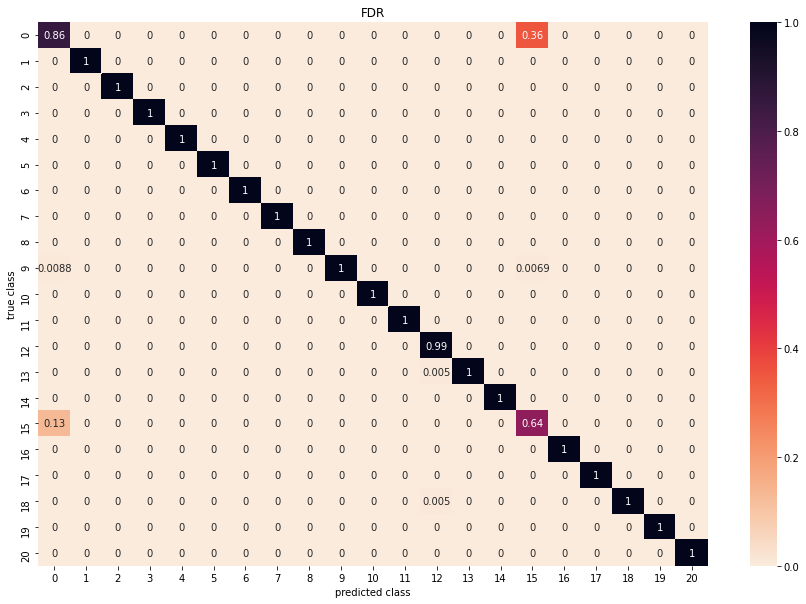

In [37]:
plt.figure(figsize=(15, 10))
plt.title("FDR")
sns.heatmap(confusion_matrix(y_true_val, y_ans_val, normalize='pred'), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

In [38]:
TPR, FPR, ACCURACY = get_metrics(y_true_val, y_ans_val)

In [39]:
def plotting(arr, name, forward=True):
    classes = np.arange(len(arr))

    norm = plt.Normalize(arr.min(), arr.max())
    
    if forward:
        colors = plt.cm.RdYlGn(norm(arr))
    else:
        colors = plt.cm.summer(norm(arr))
        
    plt.figure(figsize=(8, 5))
    plt.title(f'{name} per class')
#     sns.barplot(x=classes, y=arr, palette=colors)
    plt.plot(arr, '-*', color='yellowgreen')
    plt.xticks(classes, ["fault_" + str(c) if c > 0 else "normal" for c in classes], rotation=90)
    plt.xlabel('class')
    plt.ylabel(f'{name}')
    plt.ylim(0, 1.1)
    plt.show()

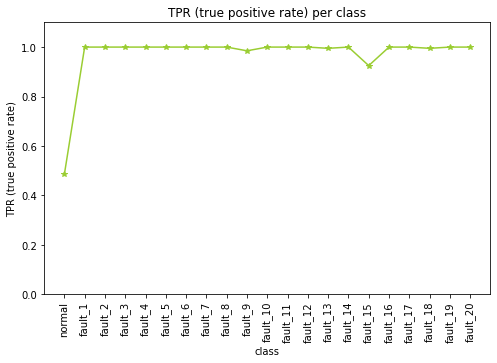

In [40]:
plotting(TPR, "TPR (true positive rate)")

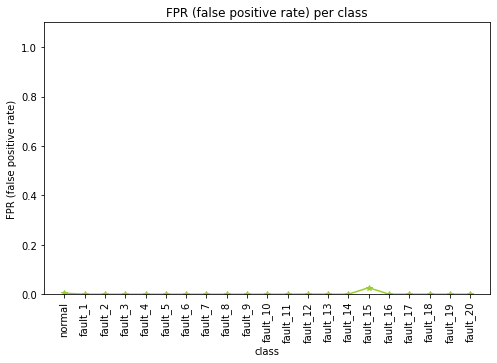

In [41]:
plotting(FPR, "FPR (false positive rate)", forward=False)

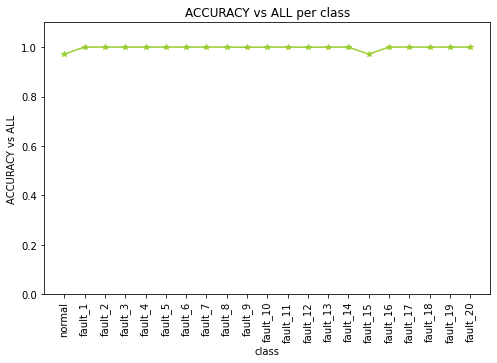

In [42]:
plotting(ACCURACY, "ACCURACY vs ALL")

> ### Test evaluation

In [43]:
gc.collect()

36552

In [44]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [45]:
raw_test[features] = scaler.transform(raw_test[features])

In [46]:
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1
raw_test = raw_test.set_index('index')

In [47]:
raw_test.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
index,,,,,,,,,,,,,,,,,,,,,
0.0,0,1.0,1,-0.061905,0.201545,-0.366697,0.396960,0.672885,0.349442,-0.223455,...,0.036876,-0.280430,-0.477229,-0.047406,0.017518,0.678059,0.641891,-0.185190,0.014966,-0.693145
0.0,0,1.0,2,-0.057595,-0.504438,0.575905,0.124438,0.421859,0.709238,-0.228836,...,-0.201046,-0.283523,-0.372900,-0.042150,0.002242,-0.482106,-0.595256,-0.173439,-0.142419,-0.548871
0.0,0,1.0,3,-0.084550,-0.483398,0.012553,-0.222560,0.110240,-0.271443,-0.251702,...,-0.059070,-0.263817,-0.348612,-0.062236,0.011582,1.286104,-0.800952,-0.174777,-0.062251,0.333051
0.0,0,1.0,4,-0.063137,-0.829377,0.121173,-0.098154,0.421859,-0.105874,-0.246322,...,-0.086261,-0.279133,-0.173902,-0.082698,0.016885,0.675348,0.681334,-0.177046,-0.119325,-0.335875
0.0,0,1.0,5,-0.295060,-0.186512,0.597077,-0.170677,-0.002289,0.123376,-0.195209,...,-0.193666,-0.417724,-0.176248,-0.042244,-0.176629,0.075099,-0.747937,-0.171810,-0.087889,-0.022812


In [48]:
class DataTEST(Dataset):

    def __init__(self, X):
    
        self.X = X
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[FAULT_START_TEST:, :]
        target = self.X.loc[idx]['faultNumber'].values[FAULT_START_TEST:]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [49]:
test_ds = DataTEST(raw_test)
test_dl = DataLoader(test_ds, batch_size=512)

In [50]:
%%time

metrics = dict()
y_ans_test_all = []

y_ans_test, y_true_test = [], []

start = time.time()

model.eval()
for (X_batch_test, y_batch_test) in tqdm(test_dl):

#     X_batch_lengths_test = torch.tensor([seq_length]*len(X_batch_test)).to(device)

    X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

    y_pred_test = model(X_batch_test, None)

    y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
    y_pred_class = y_pred_prob.max(dim=-1)[1]

    y_ans_test.append(y_pred_class.cpu().numpy())
    y_true_test.append(y_batch_test.cpu().numpy())

    end = time.time()

print(f"seq_length time: {end - start}")  


seq_length time: 286.69101214408875
CPU times: user 16min 39s, sys: 7.23 s, total: 16min 46s
Wall time: 4min 46s


In [51]:
y_ans_test = np.concatenate(y_ans_test, axis=0)

y_true_test = np.concatenate(y_true_test, axis=0)

In [52]:
TPR, FPR, ACCURACY = get_metrics(y_true_test[:, -1], y_ans_test[:, -1])

TPR, FPR, ACCURACY

(array([0.466, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 0.988, 0.992, 1.   , 0.982, 1.   , 1.   ,
        0.998, 1.   , 1.   ]),
 array([0.0001, 0.    , 0.    , 0.    , 0.    , 0.0005, 0.0004, 0.    ,
        0.    , 0.    , 0.0009, 0.    , 0.    , 0.    , 0.    , 0.0267,
        0.    , 0.    , 0.0001, 0.    , 0.    ]),
 array([0.97447619, 1.        , 1.        , 1.        , 1.        ,
        0.99952381, 0.99961905, 1.        , 1.        , 1.        ,
        0.99914286, 1.        , 0.99942857, 0.99961905, 1.        ,
        0.97371429, 1.        , 1.        , 0.99980952, 1.        ,
        1.        ]))

In [53]:
detection_delay = get_detection_delay(y_true=y_true_test[:, -1], y_pred=y_ans_test)

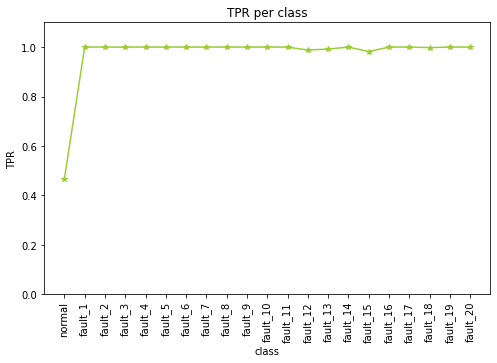

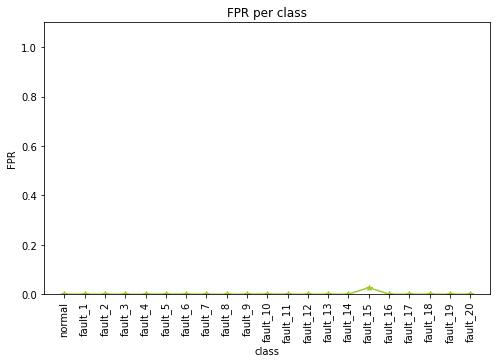

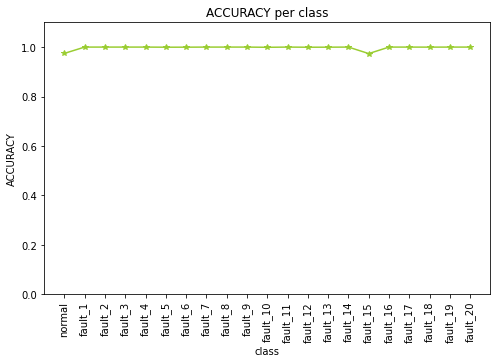

In [54]:
plotting(TPR, "TPR")
plotting(FPR, "FPR")
plotting(ACCURACY, "ACCURACY")

In [55]:
detection_delay_mean = {}
for (k, v) in detection_delay.items():
    detection_delay_mean[k] = np.nanmean(np.clip(v, 0, np.inf))

### Почему получилось -9223372036854775808

In [56]:
detection_delay[15]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

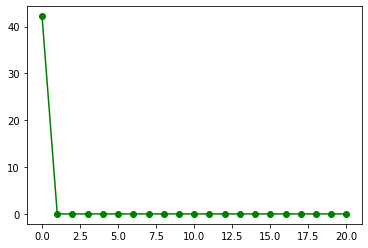

In [57]:
plt.plot(np.array(list(detection_delay_mean.values())), '-go')
plt.show()

In [58]:
# процент случаев когда правильный ответ с первого же объекта последовательсности
np.mean(y_ans_test.max(1) == y_ans_test.mean(1))

0.9767619047619047

In [59]:
np.mean(y_ans_test.min(1) == y_ans_test.mean(1))

0.9767619047619047

In [60]:
test_ds[0][0][:5, :].size()

torch.Size([5, 52])

In [61]:
model(test_ds[0][0][:1, :].unsqueeze(0).to(device), None).size()

torch.Size([1, 1, 21])

In [62]:
model(test_ds[0][0][:1, :].unsqueeze(0).to(device), None)

tensor([[[ -0.3341, -14.9856, -10.3682,  -0.2768,  -9.4926, -13.2708,  -8.6860,
          -10.5185,  -8.3094,  -2.4039, -11.2409, -13.5834, -16.1568,  -9.3418,
          -11.7313,  -2.3253, -13.6437, -10.0422, -13.3284,  -5.6377,  -7.7849]]],
       device='cuda:5')

In [66]:
for i in range(2, 10):
    print(model(test_ds[9999][0][:i, :].unsqueeze(0).to(device), None).max(dim=-1)[1])

tensor([[15, 15]], device='cuda:5')
tensor([[15, 15, 15]], device='cuda:5')
tensor([[15, 15, 15, 15]], device='cuda:5')
tensor([[9, 9, 9, 9, 9]], device='cuda:5')
tensor([[0, 0, 0, 0, 0, 0]], device='cuda:5')
tensor([[19, 19, 19, 19, 19, 19, 19]], device='cuda:5')
tensor([[19, 19, 19, 19, 19, 19, 19, 19]], device='cuda:5')
tensor([[19, 19, 19, 19, 19, 19, 19, 19, 19]], device='cuda:5')


In [64]:
model(test_ds[9999][0][:10, :].unsqueeze(0).to(device), None).max(dim=-1)[1]

tensor([[19, 19, 19, 19, 19, 19, 19, 19, 19, 19]], device='cuda:5')

In [ ]:
test_ds[0][0].unsqueeze(0).size()

In [ ]:
class TwinModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm_1 = nn.LSTM(
                        input_size=self.input_size[0], 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.lstm_2 = nn.LSTM(
                        input_size=self.input_size[1],
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=2*self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x_1 = x[:, :, :41]
        x_2 = x[:, :, 41:]
        
        x_1, _ = self.lstm_1(x_1)
        x_2, __ = self.lstm_2(x_2)
        
        x_3 = torch.cat((x_1[:, -1], x_2[:, -1]), dim=-1)
        
        x = self.head(x_3)
        
        return x